# makemore: part 3


In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline
device = "cpu"

# reproducibility
random.seed(42)
g = torch.Generator(device=device).manual_seed(42)
device

'cpu'

In [40]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [41]:
len(words)

32033

In [42]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [43]:
# context length: how many characters do we take to predict the next one?
block_size = 3


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(X.shape, Y.shape)
    return X, Y


random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## loss log

### original:

train 2.1245384216308594
val 2.168196439743042

### fix softmax confidently wrong:

train 2.07
val 2.13

### fix tanh layer too saturated at init:

train 2.0355966091156006
val 2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:

train 2.0376641750335693
val 2.106989622116089

### add batch norm layer

train 2.0668270587921143
val 2.104844808578491


# SUMMARY + PYTORCHIFYING -----------


In [44]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g, device=device) / fan_in**0.5
        self.bias = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 16  # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd), generator=g, device=device)
layers = [
    # block 1
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # block 2
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # block 3
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # block 4
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # block 5
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    # output layer
    Linear(n_hidden, vocab_size, bias=False),
    BatchNorm1d(vocab_size),
]

ZERO_INIT = True

with torch.no_grad():
    if ZERO_INIT:
        # E01: set *all* learnable weights/biases to zero
        C.zero_()
        for layer in layers:
            if isinstance(layer, Linear):
                layer.weight.zero_()
                if layer.bias is not None:
                    layer.bias.zero_()
            elif isinstance(layer, BatchNorm1d):
                layer.gamma.zero_()
                layer.beta.zero_()
    else:
        # last layer: make less confident
        layers[-1].gamma *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

2420


In [45]:
# same optimization as last time
max_steps = 5000
batch_size = 32
lossi = []
ud = []
bn_bias = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 500 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        eps = 1e-12
        ud.append([((lr * p.grad).std() / (p.data.std() + eps)).log10().item() for p in parameters])
        bn_bias.append(layers[-1].beta.detach().cpu().clone())

      0/   5000: 3.2958
    500/   5000: 2.6554
   1000/   5000: 2.9928
   1500/   5000: 2.9084
   2000/   5000: 3.0418
   2500/   5000: 2.9507
   3000/   5000: 2.7740
   3500/   5000: 2.5498
   4000/   5000: 2.8695
   4500/   5000: 3.2946


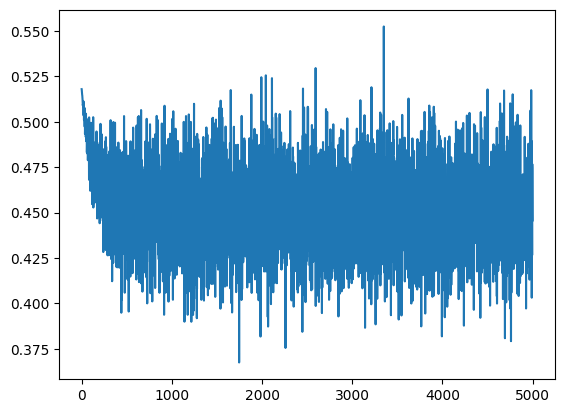

In [46]:
plt.plot(lossi)

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

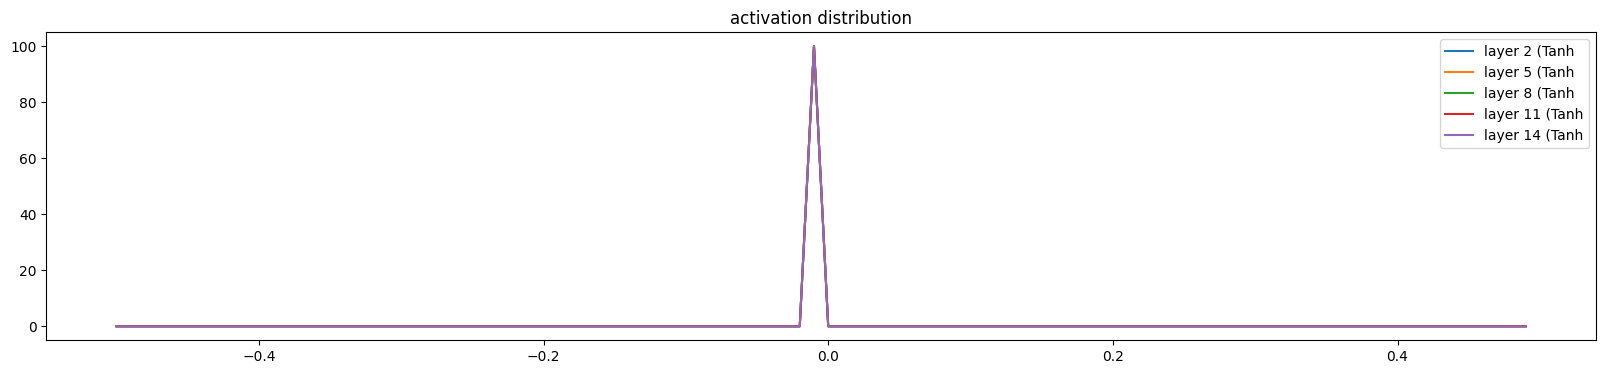

In [47]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100)
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

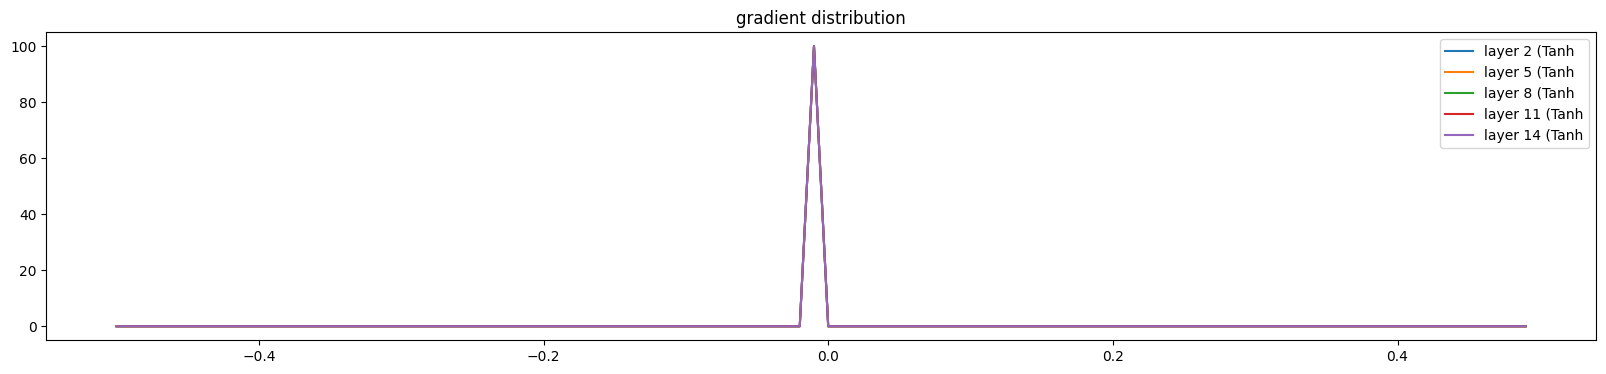

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight   (30, 16) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight   (16, 16) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight   (16, 16) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight   (16, 16) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight   (16, 16) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight   (16, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


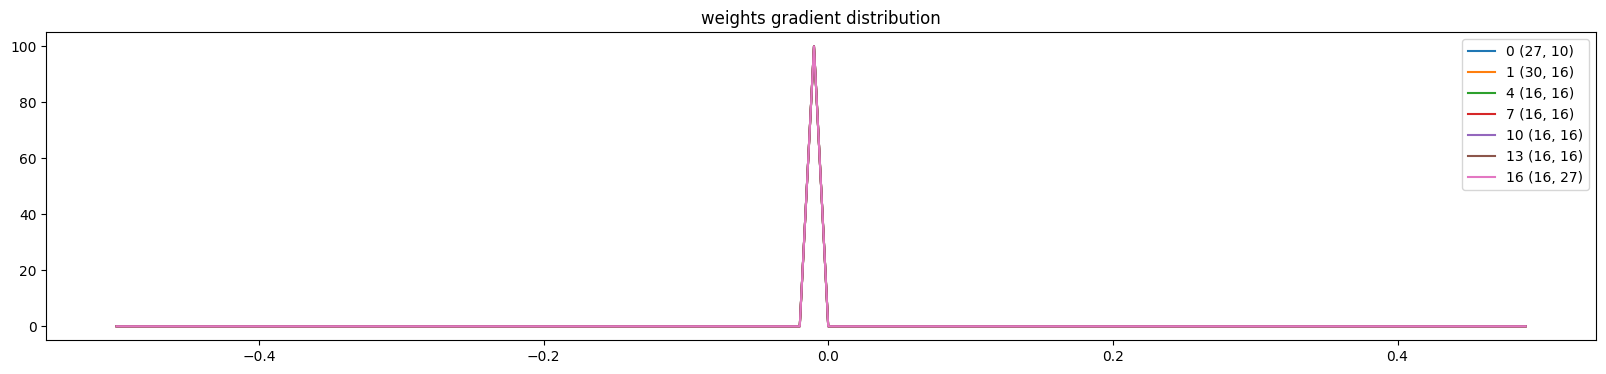

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

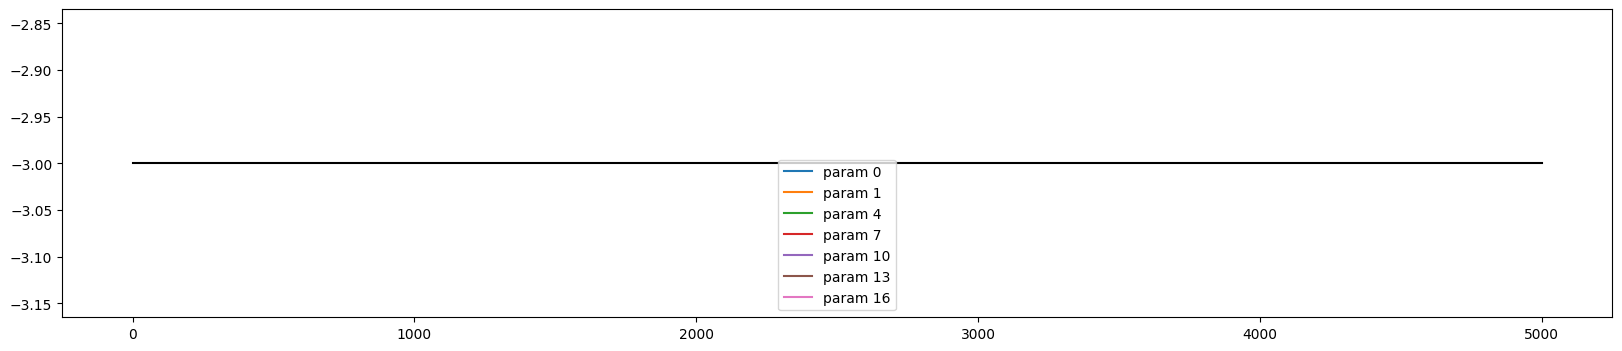

In [50]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


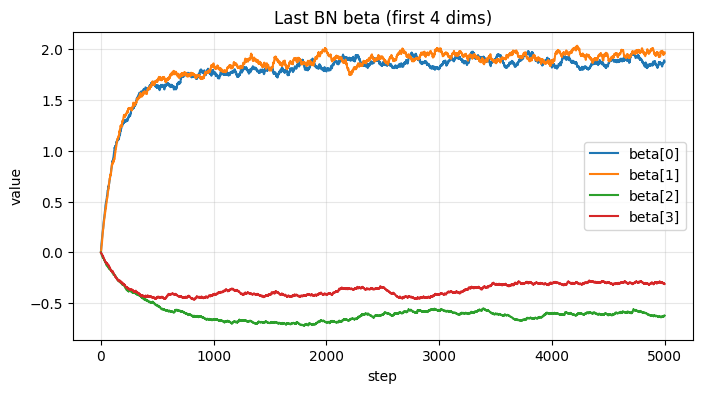

In [51]:
bn_bias_t = torch.stack(bn_bias).detach()

plt.figure(figsize=(8, 4))
for i in range(min(4, bn_bias_t.shape[1])):
    plt.plot(bn_bias_t[:, i], label=f"beta[{i}]")

plt.xlabel("step")
plt.ylabel("value")
plt.title("Last BN beta (first 4 dims)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
@torch.no_grad()
def split_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 2.8236629962921143
val 2.822333574295044


In [53]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

narmahxaae.
hlrihkimrs.
reaty.
hnaassnejr.
hnenfamesrhc.
iaeei.
.
ermaia.
ceaiivde.
lein.
h.
.
m.
.
oin.
qeijn.
s.
lilea.
.
adbi.
